# Board Game Ratings Project

## Introduction to the Dataset
This dataset contains data on board games from the BoardGameGeek (BGG) [website](https://boardgamegeek.com/) from February 2021. BoardGameGeek is an online community dedicated to board games and card games. It has over 2 million registered members who can contribute game ratings, reviews, images, and videos.

The dataset contains the following information on over 20,000 board games:
- ID: game id number assigned by BGG
- Name: title of game
- Year Published: year the game was first published
- Min Players: recommended minimum number of players
- Max Players: recommended maximum number of players
- Play Time: average time to play the game
- Min Age: minimum recommended age for the game
- Users Rated: number of BGG users who rated the game
- Rating Average: average rating on a scale of 1-10
- BGG Rank: BGG ranking
- Complexity Average: average complexity rating on a scale from 1 (light) to 5 (heavy)
- Owned Users: number of BGG users who say they own the game
- Mechanics: game mechanics, suggested by BGG users
- Domains: game type, suggested by BGG users

Members submit board game details to the BoardGameGeek database. Many of the fields above are submitted in this process, including Name, Year Published, Min Players, Max Players, Play Time, Min Age, and Mechanics. Most of these fields are not required in the submission, so there may be missing values in the dataset. BGG members can rate any game in the database on a scale of 1-10. These ratings are aggregated to produce the Rating Average, BGG Rank, and Users Rated fields. A game is given a rank only if it has at least 30 user ratings. Unranked games are not included in this dataset. BGG members can optionally say whether they own a game (Owned Users), rate a game's complexity on a scale of 1-5 (Complexity Average), and vote on a game's domain. A game is only assigned a domain once at least 5 members have voted on it and the domain(s) with over 30% of the votes are shown.

I found this dataset on [Kaggle](https://www.kaggle.com/andrewmvd/board-games). The original author is Dilini Samarasinghe, July 5, 2021, ["BoardGameGeek Dataset on Board Games"](https://ieee-dataport.org/open-access/boardgamegeek-dataset-board-games), IEEE Dataport.

## Data Question

I'm interested in characteristics of high-rated games. I would like to know if there are certain characteristics (e.g. mechanics, domains, play time, complexity rating) that are more common in games with a high rating.

**Question: Can we predict a board game's BoardGameGeek rating based on its characteristics?**

**Hypothesis:** I am doubtful that there will be a strong correlation between a game's characteristics and its BGG rating, because there are so many factors that go into making a good game. Also there are many differing tastes and opinions on games, so I think it will be difficult to draw a clear relationship. (For example, some players love very complex games; for others, high complexity would make them give the game a low rating.) However, there may be some characteristics that have a weak correlation with the BGG rating and I'm interested in seeing what they may be!

The conclusions of this project will be useful to board game creators and producers as they consider the characteristics that influence a game's popularity. Board game enthusiasts (especially members of the BoardGameGeek community) will also be interested in the results of this analysis.

## Overview of the Data and Data Cleaning

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
import copy

#### Load the data

In [2]:
# The fields in the dataset are separated by a semi-colon and the decimal numbers use a comma instead of a dot.
df = pd.read_csv('bgg_dataset.csv', sep=';', decimal=',')
# Take a look at the first 5 rows to see what the data looks like
df.head(5)

,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,161936.0,Pandemic Legacy: Season 1,2015.0,2,4,60,13,41643,8.61,2,2.84,65294.0,"Action Points, Cooperative Game, Hand Manageme...","Strategy Games, Thematic Games"
2,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
3,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
4,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"


I won't be needing the game ID in my analysis, so I will drop that column.

In [3]:
df.drop(columns=['ID'], inplace=True)

Get some information about the dataframe:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20343 entries, 0 to 20342
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                20343 non-null  object 
 1   Year Published      20342 non-null  float64
 2   Min Players         20343 non-null  int64  
 3   Max Players         20343 non-null  int64  
 4   Play Time           20343 non-null  int64  
 5   Min Age             20343 non-null  int64  
 6   Users Rated         20343 non-null  int64  
 7   Rating Average      20343 non-null  float64
 8   BGG Rank            20343 non-null  int64  
 9   Complexity Average  20343 non-null  float64
 10  Owned Users         20320 non-null  float64
 11  Mechanics           18745 non-null  object 
 12  Domains             10184 non-null  object 
dtypes: float64(4), int64(6), object(3)
memory usage: 2.0+ MB


**Observations:**
- There are 20,343 rows of data in this dataset and 13 columns.
- There are many missing values in the 'Mechanics' and 'Domains' columns.
- Games can have more than one Mechanic and Domain. These columns contain lists of all the applicable mechanics and domains for each game. In order to include this data in my analysis, I will create a column for each mechanic and domain and one hot encode the data.

Find the number of missing values in each column.

In [5]:
df.isna().sum()

Name                      0
Year Published            1
Min Players               0
Max Players               0
Play Time                 0
Min Age                   0
Users Rated               0
Rating Average            0
BGG Rank                  0
Complexity Average        0
Owned Users              23
Mechanics              1598
Domains               10159
dtype: int64

There are a *lot* of missing values in the mechanics and domains columns. Nearly half the games don't have a domain, likely because domains are assigned by optional voting and a game must receive at least 5 votes before it is assigned a domain. 'Mechanics' is an optional field that members can fill in when they submit a game to the BGG database, so it appears that quite a few of these submissions do not have any mechanics specified. **I will replace the missing values in Mechanics with 'Unspecified' and in Domains with 'Unclassified'.**

In [6]:
df['Mechanics'].fillna('Unspecified', inplace=True)
df['Domains'].fillna('Unclassified', inplace=True)

## Exploratory Data Analysis

### Summary Statistics

I will begin my exploratory analysis with a look at the summary statistics for each numerical column.

In [7]:
round(df.describe(),2)

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,20342.00,20343.00,20343.00,20343.00,20343.00,20343.00,20343.00,20343.00,20343.00,20320.00
mean,1984.25,2.02,5.67,91.29,9.60,840.97,6.40,10172.89,1.99,1408.46
std,214.00,0.69,15.23,545.45,3.65,3511.56,0.94,5872.83,0.85,5040.18
min,-3500.00,0.00,0.00,0.00,0.00,30.00,1.05,1.00,0.00,0.00
25%,2001.00,2.00,4.00,30.00,8.00,55.00,5.82,5087.50,1.33,146.00
50%,2011.00,2.00,4.00,45.00,10.00,120.00,6.43,10173.00,1.97,309.00
75%,2016.00,2.00,6.00,90.00,12.00,385.00,7.03,15258.50,2.54,864.00
max,2022.00,10.00,999.00,60000.00,25.00,102214.00,9.58,20344.00,5.00,155312.00


#### Issues with Summary Statistics:

**Issue 1:**
Some of the mins don't make sense: Min and Max Players, Play Time, Min Age, and Complexity Average shouldn't have a minimum of 0.  I suspect that these columns have 0s in place of missing values. 

Check how many 0s there are in each of the columns:

In [8]:
(df == 0).sum(axis=0)

Name                     0
Year Published         185
Min Players             46
Max Players            161
Play Time              556
Min Age               1251
Users Rated              0
Rating Average           0
BGG Rank                 0
Complexity Average     426
Owned Users              1
Mechanics                0
Domains                  0
dtype: int64

Min Age has the highest number of 0s, at 6.1% of the data. I will replace the 0s in these columns with NaN.

In [9]:
cols = ['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Complexity Average']
df[cols] = df[cols].replace(0, np.nan)

Summary statistics again with the 0s removed:

In [10]:
round(df.describe(),2)

,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
count,20157.00,20297.00,20182.00,19787.00,19092.00,20343.00,20343.00,20343.00,19917.00,20320.00
mean,2002.46,2.02,5.72,93.86,10.23,840.97,6.40,10172.89,2.03,1408.46
std,98.73,0.68,15.28,552.84,2.78,3511.56,0.94,5872.83,0.81,5040.18
min,-3500.00,1.00,1.00,1.00,1.00,30.00,1.05,1.00,1.00,0.00
25%,2001.00,2.00,4.00,30.00,8.00,55.00,5.82,5087.50,1.33,146.00
50%,2011.00,2.00,4.00,45.00,10.00,120.00,6.43,10173.00,2.00,309.00
75%,2016.00,2.00,6.00,90.00,12.00,385.00,7.03,15258.50,2.57,864.00
max,2022.00,10.00,999.00,60000.00,25.00,102214.00,9.58,20344.00,5.00,155312.00


**Issue 2:** Why are there some negative years in the 'Year Published' column?

In [11]:
# Show rows with a negative 'Year Published'
df[df['Year Published'] < 0]

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
172,Go,-2200.0,2.0,2.0,180.0,8.0,14843,7.64,173,4.00,20398.0,"Enclosure, Square Grid",Abstract Games
1275,Backgammon,-3000.0,2.0,2.0,30.0,8.0,11680,6.54,1276,2.02,17747.0,"Advantage Token, Betting and Bluffing, Dice Ro...",Abstract Games
8174,Senet,-3500.0,2.0,2.0,30.0,6.0,664,5.82,8176,1.48,1343.0,"Dice Rolling, Roll / Spin and Move",Abstract Games
8924,The Royal Game of Ur,-2600.0,2.0,2.0,30.0,10.0,549,5.90,8926,1.31,1162.0,"Dice Rolling, Roll / Spin and Move, Square Gri...",Abstract Games
15134,Petteia,-100.0,2.0,2.0,20.0,5.0,51,6.01,15136,2.17,93.0,"Action Queue, Area Majority / Influence",Abstract Games
19648,Three Men's Morris,-1400.0,2.0,2.0,5.0,5.0,60,4.31,19650,1.25,60.0,"Pattern Building, Point to Point Movement",Abstract Games
20002,Nine Men's Morris,-1400.0,2.0,2.0,20.0,6.0,1310,5.36,20004,1.84,1642.0,"Pattern Building, Point to Point Movement",Abstract Games
20219,Marbles,-3000.0,1.0,NaN,10.0,4.0,473,4.69,20221,1.10,399.0,Flicking,Children's Games
20341,Chutes and Ladders,-200.0,2.0,6.0,30.0,3.0,3783,2.86,20343,1.02,4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games
20342,Tic-Tac-Toe,-1300.0,2.0,2.0,1.0,4.0,3275,2.68,20344,1.16,1374.0,"Paper-and-Pencil, Pattern Building","Abstract Games, Children's Games"


There are 10 games listed with negative Year Published, which represent years BCE. These are ancient games, such as Go, Backgammon and Senet. Let's take a look at how the years are distributed.

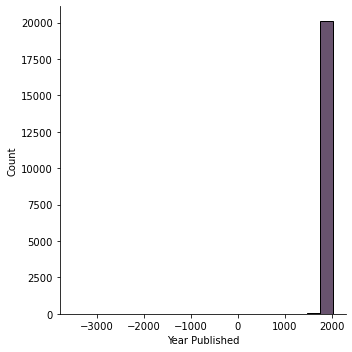

In [12]:
sns.displot(df, x='Year Published', bins=20, color='#35193e')

It's almost impossible to see anything in this histogram except games published in the last few hundred years. Let's see how many games were published since 1900.

In [13]:
# Get the number of rows and columns of the data that have 'Year Published' greater or equal to 1900
df_after_1900 = df[df['Year Published'] >= 1900]
df_after_1900.shape

(20046, 13)

20,046 games out of 20,343, or 98.5% of the games were published since 1900. Here is a histogram of the games published since 1900:

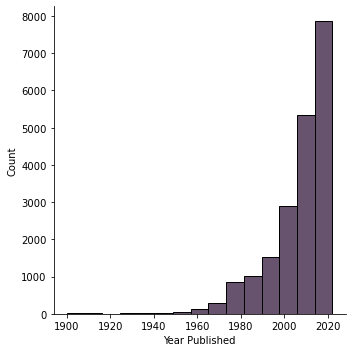

In [14]:
sns.displot(df_after_1900, x='Year Published', bins=15, color='#35193e')

This data is negatively skewed, meaning that most of the games were published in the late 20th century and early 21st century, but there are some very far-out outliers. Because of this, I will be careful about using Year Published in my linear regression model.

**Issue 3:** There is an unexpectedly large maximum value for 'Max Players': 999 players.

In [15]:
# Show rows with 'Max Players' higher than 100
df[df['Max Players'] > 100]

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
4913,Linkee!,2012.0,2.0,200.0,30.0,14.0,523,6.33,4915,1.17,1225.0,Unspecified,Unclassified
5820,Black Powder: Second Edition,2009.0,2.0,120.0,360.0,12.0,136,7.35,5822,2.69,345.0,Dice Rolling,Wargames
7025,Start Player: A Kinda Collectible Card Game,2006.0,2.0,999.0,1.0,6.0,178,6.49,7027,1.00,286.0,Unspecified,"Family Games, Party Games"
8516,"I Don't Know, What Do You Want to Play?",2007.0,2.0,999.0,5.0,8.0,87,6.76,8518,1.06,117.0,Voting,Unclassified
9983,Alchemidus,2015.0,1.0,127.0,30.0,10.0,91,6.37,9985,1.50,131.0,Dice Rolling,Unclassified
10813,Scrimish Card Game,2015.0,2.0,999.0,100.0,8.0,254,5.90,10815,1.13,898.0,Memory,Unclassified
16539,Pit Fighter: Fantasy Arena,2006.0,2.0,163.0,30.0,8.0,45,5.57,16541,1.80,204.0,"Campaign / Battle Card Driven, Hexagon Grid",Wargames
18781,The Hammer of Thor: The Game of Norse Mythology,1980.0,1.0,362.0,120.0,12.0,60,4.95,18783,3.50,179.0,"Dice Rolling, Events, Paper-and-Pencil, Role P...",Unclassified


There are 8 games with a maximum number of players over 100! Through some researching, the three games with max players = 999 don't seem to make sense. Some of the others do appear to accommodate over 100 players.

Histogram to look at the distribution of 'Max Players':

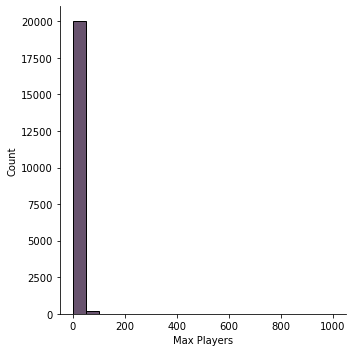

In [16]:
sns.displot(df, x='Max Players', bins=20, color='#35193e')

How many games have a maximum player limit of 20 or fewer?

In [17]:
# Get the number of rows and columns of the data that have 'Max Players' less than or equal to 20 people
df[df['Max Players'] <= 20].shape

(19934, 13)

As expected, this distribution is positively skewed, with 19,934 of the games (nearly 98%) having a maximum player limit of 20 or less. This may have to be another variable that I omit from my regression model due to large outliers.

**Issue 4:** There is an unexpectedly large maximum value for 'Play Time': 60,000 minutes (1000 hours).

In [18]:
# Show rows with 'Play Time' higher than 6000 minutes (100 hours)
df[df['Play Time'] >= 6000]

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
1282,World in Flames,1985.0,2.0,7.0,6000.0,12.0,1338,7.60,1283,4.63,2646.0,"Area Movement, Delayed Purchase, Dice Rolling,...",Wargames
1322,Empires in Arms,1983.0,2.0,7.0,12000.0,14.0,1238,7.60,1323,4.42,2129.0,"Area Movement, Dice Rolling, Movement Points, ...",Wargames
2281,Vietnam 1965-1975,1984.0,2.0,2.0,6000.0,12.0,693,7.44,2283,4.29,2058.0,"Dice Rolling, Grid Movement, Hexagon Grid, Sec...",Wargames
2290,Pacific War: The Struggle Against Japan 1941-1945,1985.0,2.0,2.0,6000.0,16.0,576,7.67,2292,4.53,1728.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
3208,Case Blue,2007.0,2.0,2.0,22500.0,12.0,289,8.26,3210,4.58,711.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
3876,Enemy at the Gates,1994.0,1.0,4.0,6000.0,12.0,257,7.64,3878,4.39,790.0,"Dice Rolling, Hexagon Grid, Simulation, Zone o...",Wargames
3886,"The Greatest Day: Sword, Juno, and Gold Beaches",2015.0,2.0,8.0,6000.0,12.0,175,8.70,3888,4.09,752.0,"Chit-Pull System, Hexagon Grid",Wargames
5195,Atlanta Is Ours,2018.0,1.0,2.0,7920.0,NaN,105,8.71,5197,3.86,566.0,"Dice Rolling, Grid Movement, Hexagon Grid, Mov...",Wargames
6035,1914: Offensive à outrance,2013.0,2.0,4.0,17280.0,NaN,108,7.98,6037,4.07,661.0,"Dice Rolling, Hexagon Grid, Simulation",Wargames
6518,1985: Under an Iron Sky,2018.0,2.0,6.0,8640.0,16.0,90,9.12,6520,4.27,363.0,"Dice Rolling, Hexagon Grid, Simulation, Zone o...",Wargames


There are 17 games with a play time of 6000 or more minutes (100+ hours). The game "The Campaign for North Africa: The Dessert War" tops the list at 60,000 minutes - more than 40 days of play time! Most of these long games are Wargames with high complexity ratings.

Histogram to look at the distribution of 'Play Time':

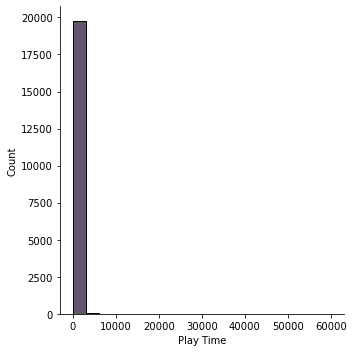

In [19]:
sns.displot(df, x='Play Time', bins=20, color='#35193e')

How many games have an average play time of 300 minutes (5 hours) or less?

In [20]:
# Get the number of rows and columns of the data that have 'Play Time' less than or equal to 300 minutes
df[df['Play Time'] <= 300].shape

(19150, 13)

Once again, this data is positively skewed with 94% of the games having a play time of 5 hours or less. Games that take days or weeks to play are outliers.

**Conclusion:**
Because of the extreme outliers in 'Year Published', 'Max Players', and 'Play Time', I suspect that they will not be very significant for predicting the BGG rating. I will be careful about using them in the linear regression model.

### Dealing with Missing Values

Now that I've replaced the suspicious 0s with NaNs, I need to decide how I will deal with the missing values. Here is a count of the missing values in each column:

In [21]:
df.isna().sum()

Name                     0
Year Published         186
Min Players             46
Max Players            161
Play Time              556
Min Age               1251
Users Rated              0
Rating Average           0
BGG Rank                 0
Complexity Average     426
Owned Users             23
Mechanics                0
Domains                  0
dtype: int64

Let's see if we have a similar distribution of the BGG rating with and without the missing values in other columns. First I need to make a dataframe with the rows with missing values dropped.

In [22]:
# Drop the rows of the dataset that have missing values
df_no_nan = df.dropna()
# Reset index so that I can concatenate dataframes later
df_no_nan = df_no_nan.reset_index(drop=True)

Next I will create histograms of the BGG Rating Average with and without missing values.

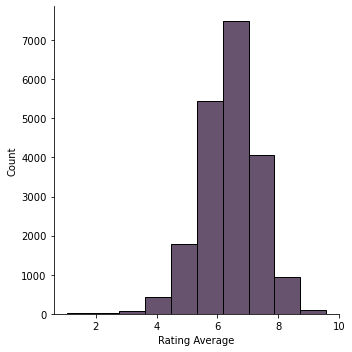

In [23]:
# Histogram of Rating Average with missing values
sns.displot(df, x='Rating Average', bins=10, color='#35193e')

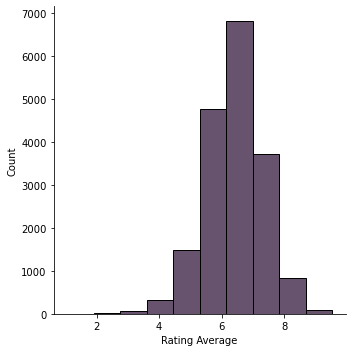

In [24]:
# Histogram of Rating Average with missing values removed
sns.displot(df_no_nan, x='Rating Average', bins=10, color='#35193e')

These distributions look quite similar: quite normally distributed with a mean around 6.5. So far I see no issues with using the dataframe with missing values removed. However, I will also look at how the missing values are distributed among the game domains and mechanics.

### Game Domains and Mechanics

The columns 'Domains' and 'Mechanics' contain lists of multiple game domains and game mechanics. I want to:
- Find out how many different domains and mechanics there are
- Get a count of each unique domain and mechanic
- Make a comparison of the count of domains and mechanics with and without missing values in other columns, so that I can decide whether I can drop the games with missing values from my dataset.

#### Game Domains

Flatten the lists in the 'Domains' column to a single list for the original dataframe (with missing values):

In [25]:
# Make a new column in the dataframe that turns the 'Domains' column into a list
df['domains_list'] = df['Domains'].apply(lambda x: x.split(', '))
# Make a list of the lists from 'domains_list' column
dom_list = list(df['domains_list'].values)
# Flatten the list of domains using list comprehension
dom_list2 = [x for sublist in dom_list for x in sublist]

Get a count of how often each domain occurs:

In [26]:
# Count the number of times each domain appears in the list
domain_count = Counter(dom_list2)

# Convert domain_count dictionary to a dataframe
df_domains = pd.DataFrame.from_dict(domain_count, orient='index').reset_index()
# Rename the columns
df_domains.columns = ['domain', 'count']
# Sort the rows by count descending
df_domains.sort_values(by=['count'], ascending=False, inplace=True)
df_domains

,domain,count
8,Unclassified,10159
2,Wargames,3316
0,Strategy Games,2205
3,Family Games,2173
1,Thematic Games,1174
5,Abstract Games,1070
7,Children's Games,849
6,Party Games,605
4,Customizable Games,297


Now I will do the same analysis on game domains in the dataframe with the missing values removed.

In [27]:
# Make the Domain Count table again from the dataframe without the NaNs, following the same process as above
df_no_nan['domains_list'] = df_no_nan['Domains'].apply(lambda x: x.split(', '))
no_nan_dom_list = list(df_no_nan['domains_list'].values)
no_nan_dom_list2 = [x for sublist in no_nan_dom_list for x in sublist]

no_nan_domain_count = Counter(no_nan_dom_list2)

df_no_nan_domains = pd.DataFrame.from_dict(no_nan_domain_count, orient='index').reset_index()
df_no_nan_domains.columns = ['domain', 'count']
df_no_nan_domains.sort_values(by=['count'], ascending=False, inplace=True)
df_no_nan_domains

,domain,count
8,Unclassified,8832
2,Wargames,2710
0,Strategy Games,2170
3,Family Games,2137
1,Thematic Games,1132
5,Abstract Games,929
7,Children's Games,797
6,Party Games,590
4,Customizable Games,268


Compare bar plots of the count of domains with and without missing values:

Text(0.5, 1.0, 'Game Domains')

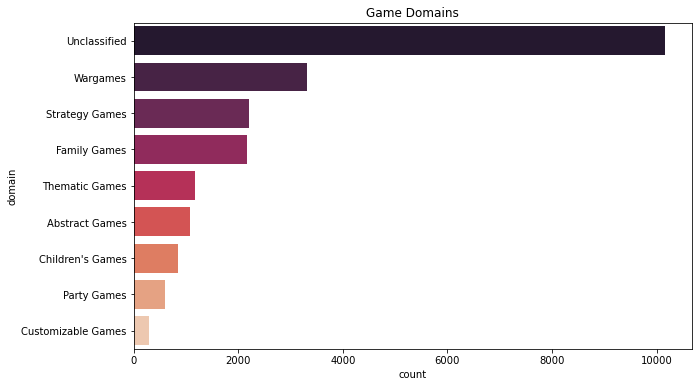

In [28]:
# Bar chart for count of domains with the missing values included
# Set the size of the chart
plt.figure(figsize=(10,6))
# Make a bar chart of the count of the domains with horizontal bars
domain_chart = sns.barplot(data=df_domains, x='count', y='domain', palette='rocket')
# Give the chart a title
domain_chart.set_title('Game Domains')

Text(0.5, 1.0, 'Game Domains (Missing Values Removed)')

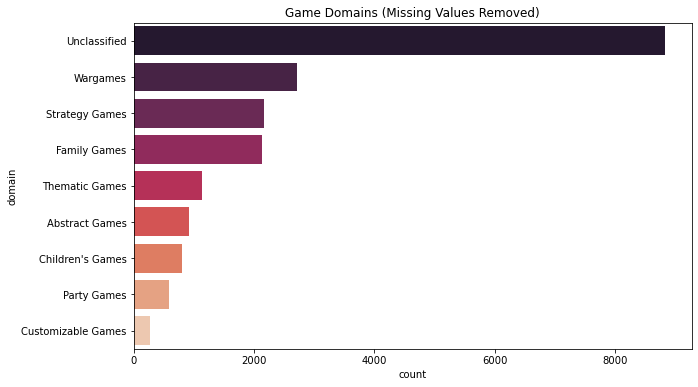

In [29]:
# Bar chart for count of domains with the missing values removed
plt.figure(figsize=(10,6))
domain_chart = sns.barplot(data=df_no_nan_domains, x='count', y='domain', palette='rocket')
domain_chart.set_title('Game Domains (Missing Values Removed)')

These two distributions look quite similar, so there shouldn't be any issues using the data with missing values removed as far as domains go.

(These bar charts also reinforce the earlier observation that there are many games with unclassified domains: almost half the dataset.)

#### Game Mechanics

Flatten the lists in the 'Mechanics' column to a single list for the original dataframe (with missing values):

In [30]:
# Make a new column in the dataframe that turns the 'Mechanics' column into a list
df['mechanics_list'] = df['Mechanics'].apply(lambda x: x.split(', '))
# Make a list of the lists from the mechanics_list column
mech_list = list(df['mechanics_list'].values)
# FLatten the list of mechanics using list comprehension
mech_list2 = [x for sublist in mech_list for x in sublist]

Get a count of how often each mechanic occurs:

In [31]:
# Count the number of times each mechanic appears in the list
mechanics_count = Counter(mech_list2)

# Count the number of unique game mechanics
len(pd.unique(mech_list2))

183

There are 183 different game mechanics! This is too many for me to handle in this analysis, so I will narrow it down to the mechanics that occur in over 1000 games.

In [32]:
# Convert mechanics_count dictionary to dataframe
df_mechanics = pd.DataFrame.from_dict(mechanics_count, orient='index').reset_index()
# Rename the columns
df_mechanics.columns = ['mechanic', 'count']
# Sort the rows by count descending
df_mechanics.sort_values(by=['count'], ascending=False, inplace=True)

# Limit to the game mechanics that occur in over 1000 games
df_top_mech = df_mechanics[df_mechanics['count'] > 1000]
df_top_mech

,mechanic,count
40,Dice Rolling,5672
9,Hand Management,4152
21,Set Collection,2733
18,Variable Player Powers,2534
10,Hexagon Grid,2253
56,Simulation,1944
31,Card Drafting,1730
35,Tile Placement,1692
12,Modular Board,1623
173,Unspecified,1598


Now I will drop the rows with missing values from the dataframe and do the same analysis on game mechanics, again limiting it to the mechanics that occur over 1000 times.

In [33]:
# Create the 'mechanics_list' column in the dataframe df_no_nan
df_no_nan['mechanics_list'] = df_no_nan['Mechanics'].apply(lambda x: x.split(', '))
# Follow same steps as above to flatten the list of mechanics, make a table to count the mechanics, and limit it to the mechanics that occur over 1000 times
no_nan_mech_list = list(df_no_nan['mechanics_list'].values)
no_nan_mech_list2 = [x for sublist in no_nan_mech_list for x in sublist]

no_nan_mechanics_count = Counter(no_nan_mech_list2)

df_no_nan_mechanics = pd.DataFrame.from_dict(no_nan_mechanics_count, orient='index').reset_index()
df_no_nan_mechanics.columns = ['mechanic', 'count']
df_no_nan_mechanics.sort_values(by=['count'], ascending=False, inplace=True)

# Limit it to the mechanics that occur over 1000 times
df_no_nan_top_mech = df_no_nan_mechanics[df_no_nan_mechanics['count'] > 1000]
df_no_nan_top_mech

,mechanic,count
40,Dice Rolling,4972
9,Hand Management,3851
21,Set Collection,2586
18,Variable Player Powers,2337
10,Hexagon Grid,1847
56,Simulation,1645
31,Card Drafting,1637
35,Tile Placement,1591
12,Modular Board,1533
38,Area Majority / Influence,1426


Compare bar plots of the count of the most common mechanics with and without missing values:

Text(0.5, 1.0, 'Most Common Game Mechanics')

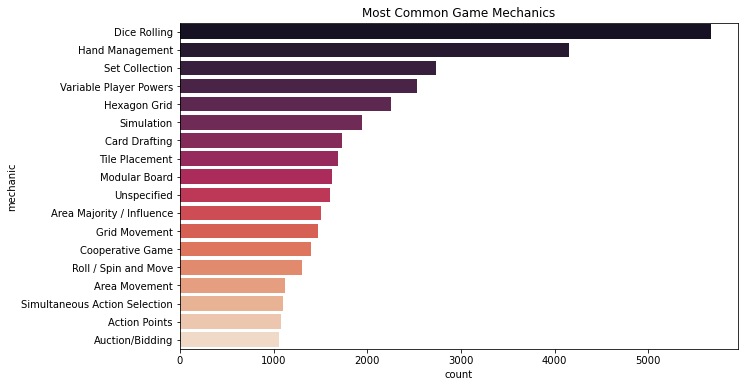

In [34]:
# Bar chart for count of most common mechanics with the missing values included
# Set the chart size
plt.figure(figsize=(10,6))
# Make a bar chart of the count of the mechanics with horizontal bars
mech_chart = sns.barplot(data=df_top_mech, x='count', y='mechanic', palette='rocket')
# Give the chart a title
mech_chart.set_title('Most Common Game Mechanics')

Text(0.5, 1.0, 'Most Common Game Mechanics (Missing Values Removed)')

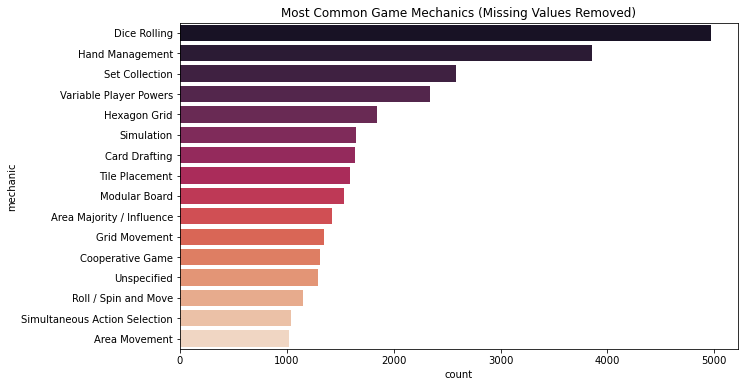

In [35]:
# Bar chart for count of most common mechanics with the missing values removed
plt.figure(figsize=(10,6))
mech_chart_no_nan = sns.barplot(data=df_no_nan_top_mech, x='count', y='mechanic', palette='rocket')
mech_chart_no_nan.set_title('Most Common Game Mechanics (Missing Values Removed)')

There are some differences in these distributions:
- The Unspecified category lost more games than any other category by removing missing values and moved down in the ranking from 10th to 13th. Otherwise the orders are almost the same.
- The Hexagon Grid mechanic also lost more games than most other categories.
- There are two fewer categories that passed the over-1000 criteria, leaving 16 mechanics rather than 18.

**The missing values are biased toward the Unspecified and Hexagon Grid mechanics.** I will use the dataframe with the missing values removed, but this means that, with regard to games with Unspecified and Hexagon Grid mechanics, the results of my analysis are only valid for those games that do not have missing values. For games with other mechanics, we can generalize the results to those that have missing information.

### One Hot Encoding
The best tool to answer my data question is a linear regression model. In order to run a linear regression on the data, I will use one hot encoding to change the game mechanics and domains into columns with 0s and 1s. I will just be considering mechanics that occur more than 1000 times in the data (top 16 mechanics), and I will use the dataframe with missing values removed.

#### Mechanics List
I want a padded list for only the game mechanics that appear in over 1000 games.

In [36]:
# Define the list padding function
def pad_mech_sublist(sublst):
    new_mech_list = []
    # Run through the list of mechanics that have a count higher than 1000.
    for mechanic in ['Dice Rolling', 'Hand Management', 'Set Collection', 'Variable Player Powers', 'Hexagon Grid', 'Simulation', 
                     'Card Drafting', 'Tile Placement', 'Modular Board', 'Area Majority / Influence', 'Grid Movement', 
                     'Cooperative Game', 'Unspecified', 'Roll / Spin and Move', 'Simultaneous Action Selection', 'Area Movement']:
        # If the mechanic appears in that list, append the mechanic name.
        if mechanic in sublst:
            new_mech_list.append(mechanic)
        # If the mechanic does not appear in that list, append the mechanic name with 0 at the end.
        else:
            new_mech_list.append(mechanic + '0')
    return new_mech_list

# Pass the no_nan_mech_list into this function
mech_frame = list(map(pad_mech_sublist, no_nan_mech_list))

Turn the lists in mech_frame into a dataframe with 0s and 1s:

In [37]:
# Define a function to sort the lists alphabetically
def sort_sublists(lst):
    for sublist in lst:
        sublist.sort()
    return

# Pass mech_frame into the sorting function
sort_sublists(mech_frame)

# Convert into a dataframe with column headers
mech_frame = pd.DataFrame(mech_frame, columns=['Area Majority / Influence', 'Area Movement', 'Card Drafting', 
                                               'Cooperative Game', 'Dice Rolling', 'Grid Movement', 'Hand Management', 
                                               'Hexagon Grid', 'Modular Board', 'Roll / Spin and Move', 'Set Collection', 
                                               'Simulation', 'Simultaneous Action Selection', 'Tile Placement', 'Unspecified', 
                                               'Variable Player Powers'])

# Define the dictionary to convert the values into 0s and 1s
mech_conversion = {'Area Majority / Influence':1, 'Area Majority / Influence0':0, 
                   'Area Movement':1, 'Area Movement0':0, 
                   'Card Drafting':1, 'Card Drafting0':0, 
                   'Cooperative Game':1, 'Cooperative Game0':0, 
                   'Dice Rolling':1, 'Dice Rolling0':0, 
                   'Grid Movement':1, 'Grid Movement0':0, 
                   'Hand Management':1, 'Hand Management0':0, 
                   'Hexagon Grid':1, 'Hexagon Grid0':0, 
                   'Modular Board':1, 'Modular Board0':0, 
                   'Roll / Spin and Move':1, 'Roll / Spin and Move0':0, 
                   'Set Collection':1, 'Set Collection0':0, 
                   'Simulation':1, 'Simulation0':0,
                   'Simultaneous Action Selection':1, 'Simultaneous Action Selection0':0,
                   'Tile Placement':1, 'Tile Placement0':0,
                   'Unspecified':1, 'Unspecified0':0,
                   'Variable Player Powers':1, 'Variable Player Powers0':0}

# Apply the conversion to the dataframe
mech_frame = mech_frame.applymap(lambda x: mech_conversion[x])

Now I have a dataframe with the game mechanic names as the column headers and a 0 or 1 in each column. 0 indicates that the game does not include the mechanic; 1 indicates that it does.

In [38]:
mech_frame.head()

,Area Majority / Influence,Area Movement,Card Drafting,Cooperative Game,Dice Rolling,Grid Movement,Hand Management,Hexagon Grid,Modular Board,Roll / Spin and Move,Set Collection,Simulation,Simultaneous Action Selection,Tile Placement,Unspecified,Variable Player Powers
0,0,0,0,1,0,1,1,1,1,0,0,0,1,0,0,1
1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,1
4,1,0,0,0,1,1,0,1,1,0,0,0,0,0,0,1


#### Domains List
I want a padded list for all the game domains.

In [39]:
# Define the list padding function
def pad_dom_sublist(sublst):
    sublst = copy.copy(sublst)
    if 'Strategy Games' not in sublst:
        sublst.append('Strategy Games0')
    if 'Thematic Games' not in sublst:
        sublst.append('Thematic Games0')
    if 'Wargames' not in sublst:
        sublst.append('Wargames0')
    if 'Family Games' not in sublst:
        sublst.append('Family Games0')
    if 'Customizable Games' not in sublst:
        sublst.append('Customizable Games0')
    if 'Abstract Games' not in sublst:
        sublst.append('Abstract Games0')
    if 'Party Games' not in sublst:
        sublst.append('Party Games0')
    if "Children's Games" not in sublst:
        sublst.append("Children's Games0")
    if 'Unclassified' not in sublst:
        sublst.append('Unclassified0')
    return sublst

# Pass the no_nan_dom_list into this function
dom_frame = list(map(pad_dom_sublist, no_nan_dom_list))

Turn the lists in dom_frame into a dataframe with 0s and 1s:

In [40]:
# Pass dom_frame into the alphabetical sorting function defined above
sort_sublists(dom_frame)

# Convert into a dataframe with column headers
dom_frame = pd.DataFrame(dom_frame, columns=['Abstract Games', "Children's Games", 'Customizable Games', 'Family Games', 
                                            'Party Games', 'Strategy Games', 'Thematic Games', 'Unclassified', 'Wargames'])

# Convert the values into 0s and 1s
dom_conversion = {'Abstract Games':1, 'Abstract Games0':0, 
                  "Children's Games":1, "Children's Games0":0, 
                  'Customizable Games':1, 'Customizable Games0':0,
                  'Family Games':1, 'Family Games0':0, 
                  'Party Games':1, 'Party Games0':0, 
                  'Strategy Games':1, 'Strategy Games0':0, 
                  'Thematic Games':1, 'Thematic Games0':0, 
                  'Unclassified':1, 'Unclassified0':0, 
                  'Wargames':1, 'Wargames0':0}

# Apply the conversion to the dataframe
dom_frame = dom_frame.applymap(lambda x: dom_conversion[x])

Now I have a dataframe with the game domain names as the column headers and a 0 or 1 in each column. 0 indicates that the game does not belong in the domain; 1 indicates that it does.

In [41]:
dom_frame.head()

,Abstract Games,Children's Games,Customizable Games,Family Games,Party Games,Strategy Games,Thematic Games,Unclassified,Wargames
0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,1,1,0,0


#### Concatenate all three dataframes

In [42]:
# Concatenate the two one-hot-encoded dataframes I just made with the main dataframe (with missing values removed)
df_final = pd.concat([df_no_nan, mech_frame, dom_frame], axis=1)

# Drop the columns I no longer need since this information is encoded with 0s and 1s.
df_final.drop(columns=['Mechanics', 'Domains', 'mechanics_list', 'domains_list'], inplace=True)

Here is the final dataframe that I can use for my analysis:

In [43]:
df_final.head()

,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,...,Variable Player Powers,Abstract Games,Children's Games,Customizable Games,Family Games,Party Games,Strategy Games,Thematic Games,Unclassified,Wargames
0,Gloomhaven,2017.0,1.0,4.0,120.0,14.0,42055,8.79,1,3.86,...,1,0,0,0,0,0,1,1,0,0
1,Pandemic Legacy: Season 1,2015.0,2.0,4.0,60.0,13.0,41643,8.61,2,2.84,...,1,0,0,0,0,0,1,1,0,0
2,Brass: Birmingham,2018.0,2.0,4.0,120.0,14.0,19217,8.66,3,3.91,...,0,0,0,0,0,0,1,0,0,0
3,Terraforming Mars,2016.0,1.0,5.0,120.0,12.0,64864,8.43,4,3.24,...,1,0,0,0,0,0,1,0,0,0
4,Twilight Imperium: Fourth Edition,2017.0,3.0,6.0,480.0,14.0,13468,8.70,5,4.22,...,1,0,0,0,0,0,1,1,0,0


## Analyzing the Data
### Linear Regression Model Using Ordinary Least Squares

This model is to determine whether the BGG Average Rating of a game can be determined by characteristics of the game.

**Dependent Variable:** 'Rating Average'

**Independent Variables:** I will not use 'BGG Rank' as an independent variable since it is based on the rating. For my first model, I will use all the remaining numerical columns as independent variables.

In [44]:
# Make a dataframe of the data I will use for my linear regression model
regression_data = df_final[['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 
                                  'Rating Average', 'Complexity Average', 'Owned Users', 'Area Majority / Influence',
                                  'Area Movement', 'Card Drafting', 'Cooperative Game', 'Dice Rolling', 'Grid Movement', 
                                  'Hand Management', 'Hexagon Grid', 'Modular Board', 'Roll / Spin and Move', 'Set Collection', 
                                  'Simulation', 'Simultaneous Action Selection', 'Tile Placement', 'Unspecified',
                                  'Variable Player Powers', 'Abstract Games', "Children's Games", 'Customizable Games', 
                                  'Family Games', 'Party Games', 'Strategy Games', 'Thematic Games', 'Unclassified', 'Wargames']]

Make a correlation matrix heat map. I am particularly interested in how 'Rating Average' correlates with the other variables.

<AxesSubplot:>

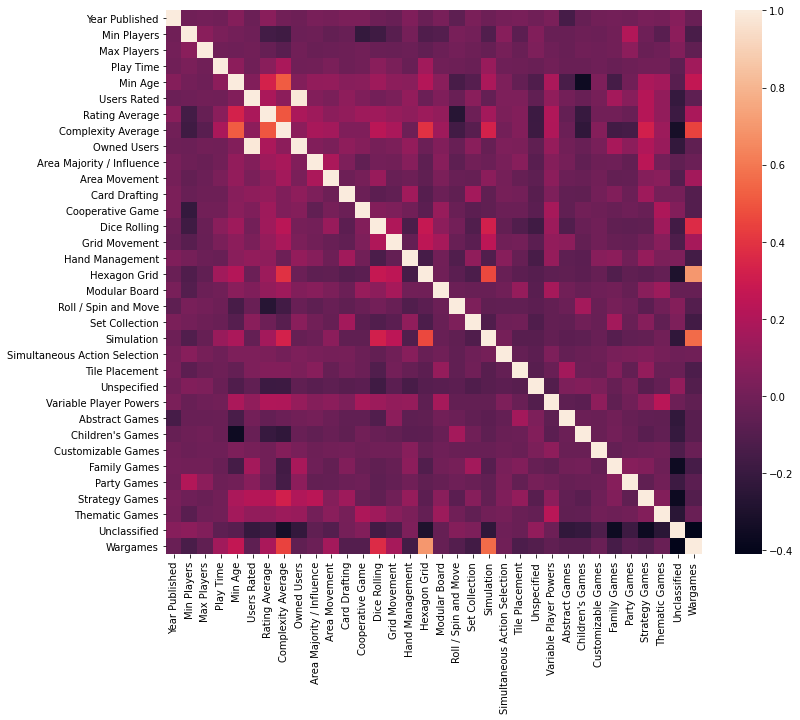

In [45]:
plt.figure(figsize=(12,10))
sns.heatmap(regression_data.corr())

The variables that are most strongly positively correlated with 'Rating Average' are 'Complexity Average' and 'Min Age'. The variable that is most negatively correlated with 'Rating Average' is the 'Roll / Spin and Move' mechanic.

#### Linear Regression Model 1

In [46]:
# Assign dependent and independent variables
dependent_vars = regression_data['Rating Average']
independent_vars = regression_data[['Year Published', 'Min Players', 'Max Players', 'Play Time', 'Min Age', 'Users Rated', 
                                  'Complexity Average', 'Owned Users', 'Area Majority / Influence','Area Movement', 
                                    'Card Drafting', 'Cooperative Game', 'Dice Rolling', 'Grid Movement', 'Hand Management', 
                                    'Hexagon Grid', 'Modular Board', 'Roll / Spin and Move', 'Set Collection', 'Simulation', 
                                    'Simultaneous Action Selection', 'Tile Placement', 'Unspecified', 'Variable Player Powers', 
                                    'Abstract Games', "Children's Games", 'Customizable Games', 'Family Games', 'Party Games', 
                                    'Strategy Games', 'Thematic Games', 'Unclassified', 'Wargames']]
independent_vars['constant'] = 1

dependent_vars = dependent_vars.apply(float)
independent_vars = independent_vars.applymap(float)

In [47]:
# Initialize and train the model
lin_reg = sm.OLS(dependent_vars, independent_vars)
reg_results = lin_reg.fit()
# Print the results
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:         Rating Average   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     312.3
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:05:58   Log-Likelihood:                -19887.
No. Observations:               18102   AIC:                         3.984e+04
Df Residuals:                   18068   BIC:                         4.011e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Year Published

#### Analysis of the model:
- Adjusted R-squared value of 0.362 shows a weak correlation.
- Prob (F-statistic) of 0.00 indicates that the model is very significant.
- There are many independent variables with a p-value above the acceptable level of 0.05: 'Max Players', 'Play Time', 'Users Rated', 'Modular Board', 'Set Collection', 'Simultaneous Action Selection', 'Tile Placement', 'Strategy Games', and 'Wargames'. 

**Note:** Recall that 'Max Players' and 'Play Time' had extreme outliers. Because of this, I am happy to remove them from the regression model. Interestingly, 'Year Published' also had extreme outliers, but it appears to be a stasitically significant variable, with a p-value of 0.

#### Linear Regression Model 2:
For this model, I will remove the variables with a p-value above 0.05 from the first model.

In [48]:
independent_vars2 = independent_vars.drop(columns=['Max Players', 'Play Time', 'Users Rated', 'Modular Board', 'Set Collection', 
                                                   'Simultaneous Action Selection', 'Tile Placement', 'Strategy Games', 'Wargames'])

lin_reg2 = sm.OLS(dependent_vars, independent_vars2)
reg_results = lin_reg2.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:         Rating Average   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     429.3
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:05:59   Log-Likelihood:                -19890.
No. Observations:               18102   AIC:                         3.983e+04
Df Residuals:                   18077   BIC:                         4.002e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Year Published        

#### Analysis of the model:
- Adjusted R-squared value and Prob (F-statistic) stayed the same as the first model.
- All the p-values are 0.001 or lower, within the acceptable level of significance.
- According to Note 2, there may be multicollinearity issues, meaning that because of the high number of variables in the model, some variables may be highly correlated with each other.

#### Linear Regression Model 3:
This model went through a few tests as I tried removing some variables to see if I could reduce the multicollinearity issues without sacrificing the adjusted R-squared value. First I tried removing 'Children's Games' or 'Min Age' because I thought those would have a strong negative correlation with each other and would also be correlated with 'Complexity Average'. However, removing either of them dropped the R-squared value. Next I tried removing 'Simulation' or 'Grid Movement' because they had the highest p-value in Model 2. Removing either one of them kept the adjusted R-squared value at 0.362, but removing both of them dropped it. I chose to drop 'Grid Movement' because then I could also drop 'Abstract Games' and still retain the same adjusted R-squared value.

In [49]:
independent_vars3 = independent_vars2.drop(columns=['Grid Movement', 'Abstract Games'])
lin_reg3 = sm.OLS(dependent_vars, independent_vars3)
reg_results = lin_reg3.fit()
print(reg_results.summary())

                            OLS Regression Results                            
Dep. Variable:         Rating Average   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     466.9
Date:                Tue, 14 Dec 2021   Prob (F-statistic):               0.00
Time:                        15:05:59   Log-Likelihood:                -19900.
No. Observations:               18102   AIC:                         3.985e+04
Df Residuals:                   18079   BIC:                         4.002e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Year Published        

#### Analysis of the model:
- Adjusted R-squared value and Prob (F-statistic) stayed the same as the first model. The R-squared value dropped slightly to 0.362, but since the adjusted R-squared is the same, I am willing to accept this in order to remove a few more variables.
- All the p-values are within the acceptable level of significance (under 0.05).
- There is still a large condition number indicating multicollinearity or other numerical problems; however I don't seem to be able to fix this without sacrificing the predictive value of the model.

## Answering the Question

### Can we predict a board game's BoardGameGeek rating based on its characteristics?

According to the linear regression model, there is a *weak* correlation between the board game charcteristics included in the model and the game's average rating on BoardGameGeek. This means that the predictive power of the model is not very strong but there are some general trends. This is what I was hoping to find. I did not expect a strong correlation because board games have so many different characteristics that make them appealing to different people.

### What characteristics influence a board game's BGG rating?

The linear regression model used the following independent variables to predict the BGG average rating: 

Game Characteristics: Year Published, Min Players, Min Age, Complexity Average, Owned Users

Game  Mechanics: Area Majority/Influence, Area Movement, Card Drafting, Cooperative Game, Dice Rolling, Hand Management, Hexagon Grid, Roll/Spin and Move, Simulation, Unspecified Mechanics

Game Domains: Variable Player Powers, Children's Games, Customizable Games, Family Games, Party Games, Thematic Games, Unclassified Games

### Complexity Rating
The variable that has the highest positive coefficient in the linear regression model is the Complexity Average. This means that the higher the complexity rating, the more likely the game is to have a higher BGG rating. Complexity Average also had the highest correlation with the BGG Rating in the correlation matrix. It doesn't surprise me that BoardGameGeek members tend to like more complex games. I expect that most people who like board games enough to join an online board game community would be experienced board gamers who prefer complex games over simple ones.

Here is a scatterplot showing the relationship between the BGG Rating and the Complexity Rating of games, showing the positive correlation between the two measures.

Text(0.5, 1.0, 'BGG Rating vs Complexity Rating')

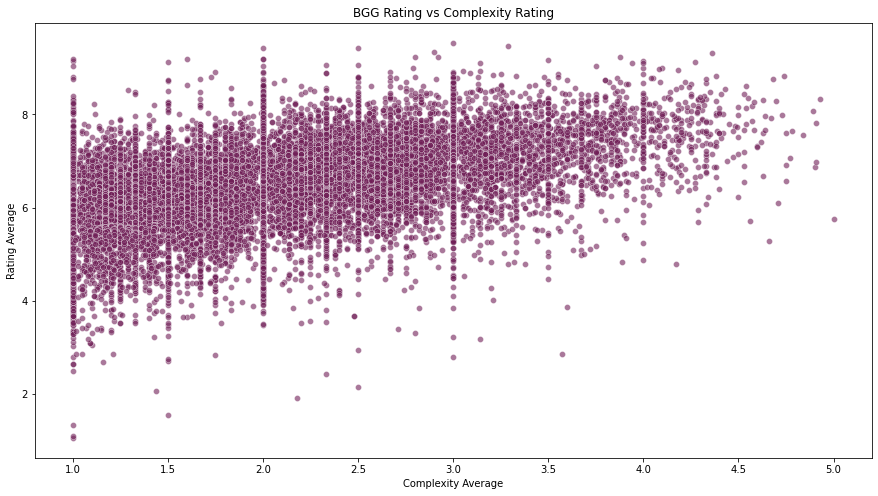

In [50]:
plt.figure(figsize=(15,8))
scatterplot1 = sns.scatterplot(data=regression_data, x='Complexity Average', y='Rating Average', alpha=0.6, color='#701f57')
scatterplot1.set_title('BGG Rating vs Complexity Rating')

### Roll/Spin and Move
The variable that has the lowest negative coefficient in the linear regression model is the game mechanic Roll/Spin and Move. Roll/Spin and Move also had the highest negative correlation with the BGG Rating in the correlation matrix. This means that games with this mechanic tend to be rated lower than games that do not have it. This may be due to the fact that games where you roll dice or spin a spinner to move around a board tend to be more basic games.

Here is a bar graph showing the average BGG rating for games that have the Roll/Spin and Move mechanic and games that don't. The average BGG rating for games without the Roll/Spin and Move mechanic is about one full point higher than for games with this mechanic. This seems fairly significant on a scale of 1-10.

Text(0.5, 1.0, 'Average BGG Rating for Games With and Without a Roll/Spin and Move Mechanic')

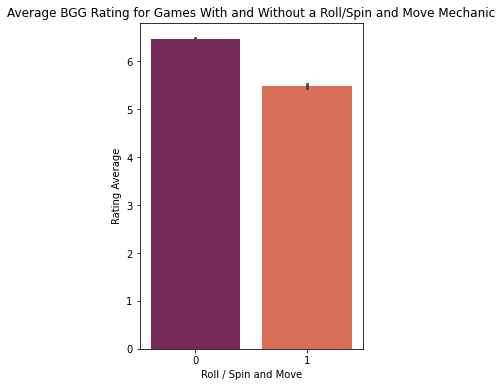

In [51]:
plt.figure(figsize=(4,6))
barplot1 = sns.barplot(data=regression_data, x='Roll / Spin and Move', y='Rating Average', palette='rocket')
barplot1.set_title('Average BGG Rating for Games With and Without a Roll/Spin and Move Mechanic')

### Ranking the Game Domains by BGG Rating

Finally, I'm interested in seeing how the different game domains relate to the BGG rating. First I need to create a dataframe showing the BGG rating of every game within each domain.

In [52]:
# Create a dataframe showing ratings of abstract games
# Get only the rows with the domain 'Abstract Games'
df_abst = df_final[df_final['Abstract Games'] == 1]
# Use only the columns 'Abstract Games' and 'Rating Average'
df_abst = df_abst[['Abstract Games', 'Rating Average']]
# Replace all the 1s in the column 'Abstract Games' with the string 'Abstract Games'
df_abst['Abstract Games'] = 'Abstract Games'
# Rename the columns
df_abst.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of children's games: same process as above
df_child = df_final[df_final["Children's Games"] == 1]
df_child = df_child[["Children's Games", 'Rating Average']]
df_child["Children's Games"] = "Children's Games"
df_child.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of customizable games
df_custom = df_final[df_final['Customizable Games'] == 1]
df_custom = df_custom[['Customizable Games', 'Rating Average']]
df_custom['Customizable Games'] = 'Customizable Games'
df_custom.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of family games
df_fam = df_final[df_final['Family Games'] == 1]
df_fam = df_fam[['Family Games', 'Rating Average']]
df_fam['Family Games'] = 'Family Games'
df_fam.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of party games
df_party = df_final[df_final['Party Games'] == 1]
df_party = df_party[['Party Games', 'Rating Average']]
df_party['Party Games'] = 'Party Games'
df_party.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of strategy games
df_strat = df_final[df_final['Strategy Games'] == 1]
df_strat = df_strat[['Strategy Games', 'Rating Average']]
df_strat['Strategy Games'] = 'Strategy Games'
df_strat.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of thematic games
df_theme = df_final[df_final['Thematic Games'] == 1]
df_theme = df_theme[['Thematic Games', 'Rating Average']]
df_theme['Thematic Games'] = 'Thematic Games'
df_theme.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of unclassified games
df_unclass = df_final[df_final['Unclassified'] == 1]
df_unclass = df_unclass[['Unclassified', 'Rating Average']]
df_unclass['Unclassified'] = 'Unclassified'
df_unclass.columns = ['Domain', 'BGG Rating']

# Create a dataframe showing ratings of wargames
df_war = df_final[df_final['Wargames'] == 1]
df_war = df_war[['Wargames', 'Rating Average']]
df_war['Wargames'] = 'Wargames'
df_war.columns = ['Domain', 'BGG Rating']

# Concatenate the frames to create the full dataframe
df_rating_by_dom = pd.concat([df_strat, df_war, df_theme, df_fam, df_custom, df_party, df_abst, df_unclass, df_child], axis=0)
df_rating_by_dom

,Domain,BGG Rating
0,Strategy Games,8.79
1,Strategy Games,8.61
2,Strategy Games,8.66
3,Strategy Games,8.43
4,Strategy Games,8.70
...,...,...
18094,Children's Games,3.42
18097,Children's Games,3.79
18099,Children's Games,3.18
18100,Children's Games,2.86


**Note:** Some games have more than one domain, that's why there are more rows in this dataframe than in df_final.

This violin plot shows the distribution of Rating Average among each game domain.

Text(0.5, 1.0, 'BGG Rating by Game Domains')

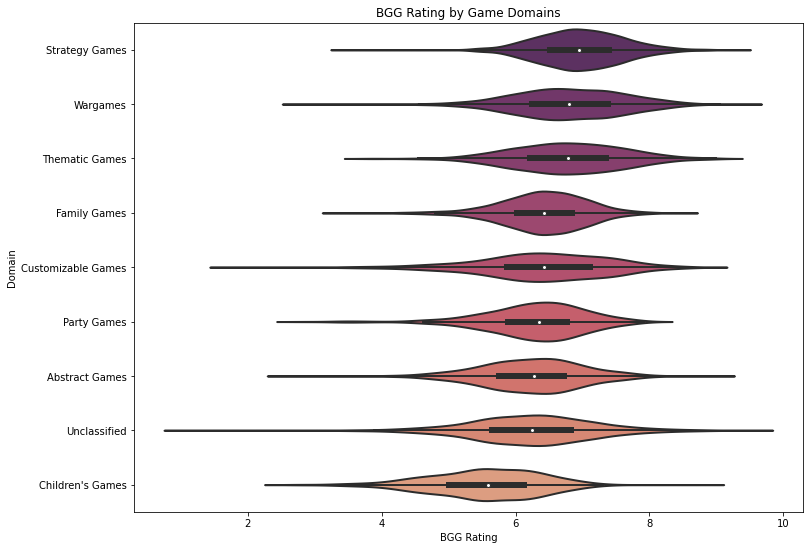

In [53]:
# Create a violinplot of BGG ratings broken out by game domains
plt.figure(figsize=(12,9))
dom_rating_chart = sns.violinplot(data=df_rating_by_dom, y='Domain', x='BGG Rating', palette='flare_r', linewidth=2)
dom_rating_chart.set_title('BGG Rating by Game Domains')

**Observations from the violin plot:**
- The game domains are arranged top to bottom from highest median BGG rating to lowest. The most highly-rated domain is Strategy Games and the lowest is Children's Games. This is unsurprising since I imagine that few BGG members are children. Strategy games tend to be more complex and children's games less complex, so this follows the patterns I observed about BGG members prefering complex games.
- As you can see from the thickness of the plots, most of the strategy games and family games have BGG ratings that are close to the median. These domains have the most normal distribution of BGG ratings.
- In the Party Games domain, the most common BGG rating is above the median, but there is a much longer long tail to the left than the right, showing that there are outliers with low ratings in this domain.
- Games that are unclassified have the widest spread of BGG ratings. I'm not surprised to see the low outliers in this category since unclassified games are generally probably less popular. I am surprised to see the long tail to the right, indicating some very high ratings for unclassified games.

### Recommendations
For game creators and publishers looking to release the next hot board game among serious board gamers, I suggest the following based on this analysis:
- Create a game that has a fairly high level of complexity. Serious board gamers like to be challenged.
- Strategy games and wargames top the list of game domains. Also consider basing the game around a strong narrative theme.
- Incorporate game mechanics that are more creative than moving around a board based on the result of a spin or dice roll.